In [1]:
import random
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.optim as optim
import ipywidgets as widgets
from PIL import Image

# tqdm for Progress Bar
from tqdm import tqdm
import tqdm.notebook as tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


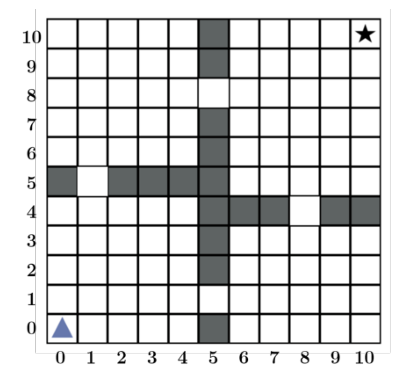

In [3]:
# Board image
img_path1 = "/content/drive/MyDrive/Colab/NU/CIVE5180/board.png"
img = Image.open(img_path1)

plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
class FourRooms(object):

    def __init__(self):
        """Define the environment as a 2-D array for easy state space reference and visualization.
        Define the state space, action space, start state and goal.
        """

        # 0 represents an empty cell; 1 represents a wall cell
        self.four_room_space = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                          [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                                          [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # Find the indices of all empty cells in the array (where the cell value is equal to zero).
        empty_cells = np.where(self.four_room_space == 0)

        # State space
        self.state_space = [[col, 10 - row] for row, col in zip(empty_cells[0], empty_cells[1])]

        # Define walls as the coordinates of non-empty cells
        wall_cells = np.where(self.four_room_space == 1)
        self.walls = [tuple([col, 10 - row]) for row, col in zip(wall_cells[0], wall_cells[1])]

        # Action space
        self.action_space = {
            "LEFT": np.array([-1, 0]),    # Move left (decrease column index)
            "RIGHT": np.array([1, 0]),    # Move right (increase column index)
            "DOWN": np.array([0, -1]),    # Move down (decrease row index)
            "UP": np.array([0, 1])        # Move up (increase row index)
        }

        # Start state
        self.start_state = [0, 0]         # bottom-left corner

        # Goal state
        self.goal_state = [10, 10]        # top-right corner


    def is_valid_state(self, state):
        """Check if the state is within bounds and not a wall."""
        # Check if the state is within the bounds of the environment
        if not (0 <= state[0] < 11 and 0 <= state[1] < 11):
            return False

        # Check if the state is a wall
        if tuple(state) in self.walls:
            return False

        return True


    def reset(self):
        """Reset the agent's state to the start state [0, 0].
        Returns both the start state and the initial reward.
        """
        state = self.start_state
        reward = 0
        return state, reward


    def step(self, state, action):
        """Perform a step in the environment.

        Args:
            state (list): The current state of the agent as [x, y] coordinates. e.g., [2, 7].
            action (str): The action the agent is taking, one of ["UP", "DOWN", "LEFT", "RIGHT"].

        Returns:
            next_state (list): The new state after the action and noise are applied.
            reward (int): The reward, which is 1 if the agent reaches the goal, otherwise 0.
        """

        if state == self.goal_state:    # Goal check
            return self.start_state, 1  # Return start state on goal reach

        # Define the probabilities for the action noise
        noise_prob = np.random.rand()

        # Apply the main action with 80% probability
        if noise_prob < 0.8:
            next_state = self.take_action(state, action)

        # Apply perpendicular actions with 10% probability each
        elif noise_prob < 0.9:
            if action == 'UP' or action == 'DOWN':
                next_state = self.take_action(state, 'LEFT' if action == 'UP' else 'RIGHT')
            else:
                next_state = self.take_action(state, 'UP' if action == 'RIGHT' else 'DOWN')
        else:
            if action == 'UP' or action == 'DOWN':
                next_state = self.take_action(state, 'RIGHT' if action == 'UP' else 'LEFT')
            else:
                next_state = self.take_action(state, 'DOWN' if action == 'RIGHT' else 'UP')

        # If the next state is invalid (into a wall or out of bounds), stay in the current state
        if next_state not in self.state_space:
            next_state = state

        # Reward is 1 if agent reaches the goal, otherwise 0
        reward = 1 if next_state == self.goal_state else 0

        return next_state, reward


    def take_action(self, state, action):
        """Determine the next state based on the current state and action.

        Args:
            state (list): The current state of the agent as [x, y] coordinates. e.g., [2, 7].
            action (str): The action the agent is taking, one of ["UP", "DOWN", "LEFT", "RIGHT"].

        Returns:
            next_state (list): The new position of the agent after applying the action.
                               If the action would take the agent into a wall or out of bounds,
                               the agent stays in the current state.
        """

        # Convert the state list to a NumPy array for easier mathematical operations.
        state = np.array(state)

        # Calculate the next state by adding the action vector to the current state.
        next_state = state + self.action_space[action]

        # Check if the computed next state is valid by verifying if it exists in self.state_space.
        return next_state.tolist() if next_state.tolist() in self.state_space else state.tolist()

In [7]:
# PLOT FUNCTION
def plot_func(res_list):
    # set the figure size
    plt.figure(figsize=(8, 6))

    # plot each trial
    for re in res_list:
        plt.plot(list(range(len(res_list[0]))), re, linestyle="--", linewidth=1, alpha=0.7)

    # plot mean reward
    mean_reward = np.array(res_list).mean(axis=0).tolist()
    plt.plot(list(range(len(res_list[0]))), mean_reward, linestyle="-", linewidth=2, color="k")

    # plot the figure
    plt.ylabel("Cumulative reward")
    plt.xlabel("Time step")
    plt.show()

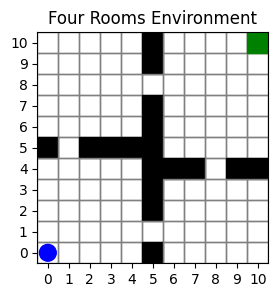

Current state: [0, 0]
Enter action (UP, DOWN, LEFT, RIGHT): UP


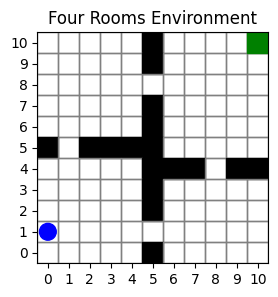

Current state: [0, 1]
Enter action (UP, DOWN, LEFT, RIGHT): UP


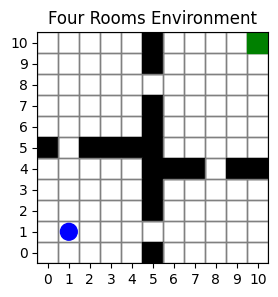

Current state: [1, 1]
Enter action (UP, DOWN, LEFT, RIGHT): UP


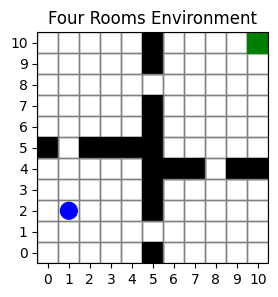

Current state: [1, 2]
Enter action (UP, DOWN, LEFT, RIGHT): UP


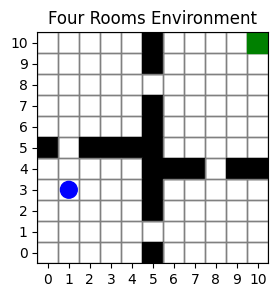

Current state: [1, 3]
Enter action (UP, DOWN, LEFT, RIGHT): UP


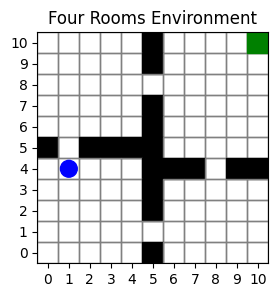

Current state: [1, 4]
Enter action (UP, DOWN, LEFT, RIGHT): UP


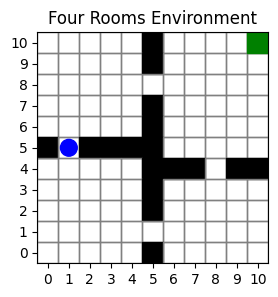

Current state: [1, 5]
Enter action (UP, DOWN, LEFT, RIGHT): UP


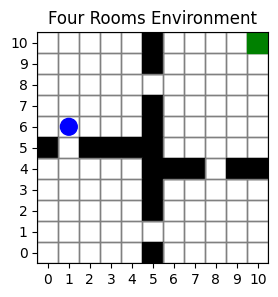

Current state: [1, 6]
Enter action (UP, DOWN, LEFT, RIGHT): UP


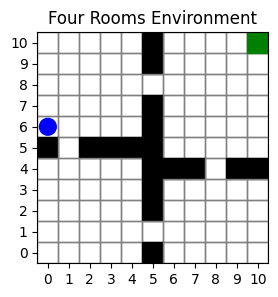

Current state: [0, 6]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


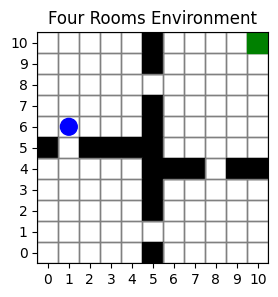

Current state: [1, 6]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


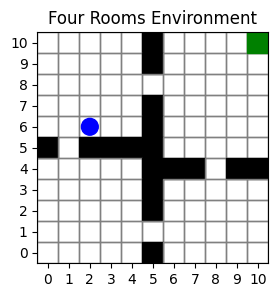

Current state: [2, 6]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


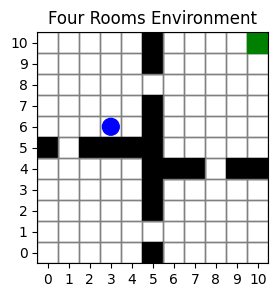

Current state: [3, 6]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


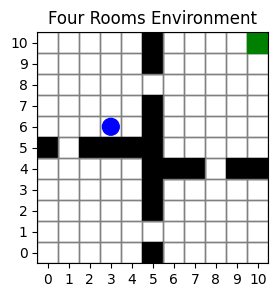

Current state: [3, 6]
Enter action (UP, DOWN, LEFT, RIGHT): UP


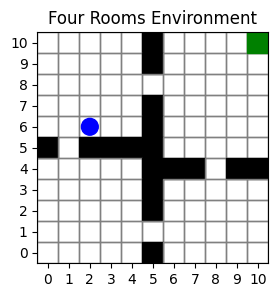

Current state: [2, 6]
Enter action (UP, DOWN, LEFT, RIGHT): UP


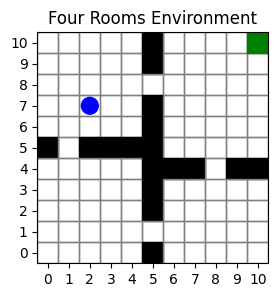

Current state: [2, 7]
Enter action (UP, DOWN, LEFT, RIGHT): UP


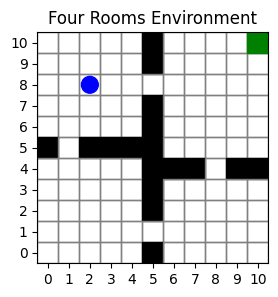

Current state: [2, 8]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


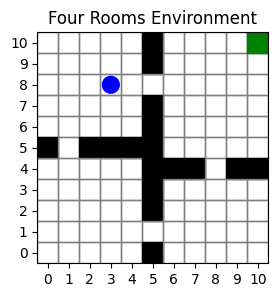

Current state: [3, 8]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


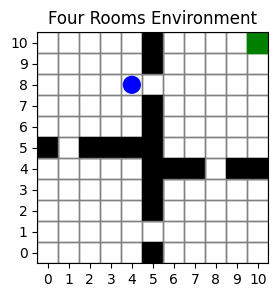

Current state: [4, 8]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


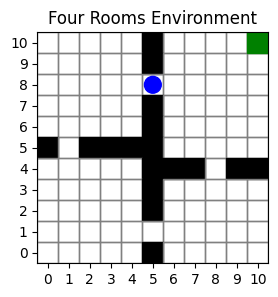

Current state: [5, 8]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


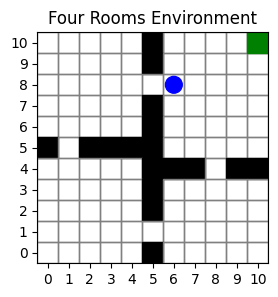

Current state: [6, 8]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


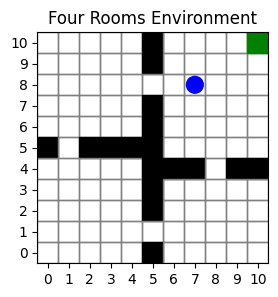

Current state: [7, 8]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


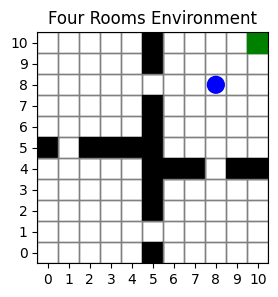

Current state: [8, 8]
Enter action (UP, DOWN, LEFT, RIGHT): 
Invalid action! Please enter one of: 'UP', 'DOWN', 'LEFT', 'RIGHT'.
Enter action (UP, DOWN, LEFT, RIGHT): UP


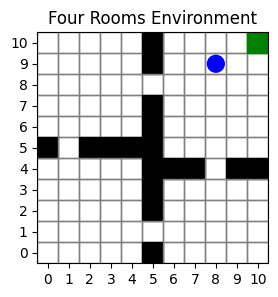

Current state: [8, 9]
Enter action (UP, DOWN, LEFT, RIGHT): UP


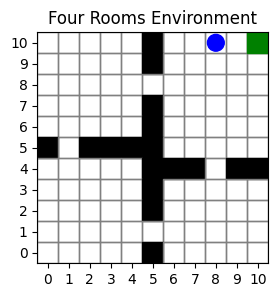

Current state: [8, 10]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


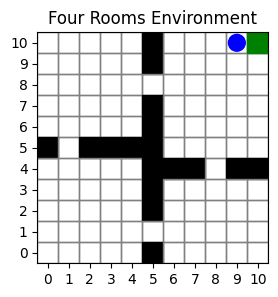

Current state: [9, 10]
Enter action (UP, DOWN, LEFT, RIGHT): RIGHT


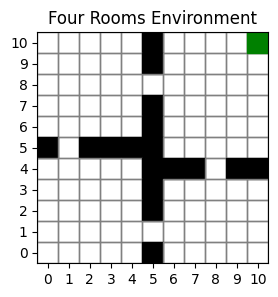

Goal reached! Resetting the agent to the start state.


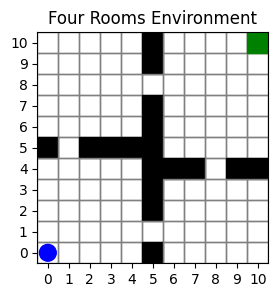

Current state: [0, 0]


In [ ]:
# MANUAL POLICY

# PLOT FUNCTION FOR VISUALIZATION
def plot_grid(env, agent_pos):
    fig, ax = plt.subplots(figsize=(3, 3))

    # Draw the environment (walls and empty cells)
    for i in range(env.four_room_space.shape[0]):
        for j in range(env.four_room_space.shape[1]):
            if env.four_room_space[i, j] == 1:
                ax.add_patch(patches.Rectangle((j, 10 - i), 1, 1, color='black'))
            else:
                ax.add_patch(patches.Rectangle((j, 10 - i), 1, 1, edgecolor='gray', fill=None))

    # Draw the agent
    ax.add_patch(patches.Circle((agent_pos[0] + 0.5, agent_pos[1] + 0.5), 0.4,
                                color='blue', label='Agent'))

    # Draw the goal
    ax.add_patch(patches.Rectangle((10, 10), 1, 1, color='green', label='Goal'))

    # Set limits, labels, and title
    plt.xlim(0, 11)
    plt.ylim(0, 11)

    # Adjust axis ticks to be centered in the cells
    ax.set_xticks(np.arange(0.5, 11.5, 1))  # Set x-ticks at the center of each grid cell
    ax.set_yticks(np.arange(0.5, 11.5, 1))  # Set y-ticks at the center of each grid cell
    ax.set_xticklabels(np.arange(0, 11, 1))  # Label x-ticks as 0, 1, 2, ..., 10
    ax.set_yticklabels(np.arange(0, 11, 1))  # Label y-ticks as 0, 1, 2, ..., 10

    # Disable all grid lines
    ax.grid(False)  # Disable grid lines entirely

    # Set the aspect ratio of the plot to be equal
    plt.gca().set_aspect('equal', adjustable='box')

    plt.title("Four Rooms Environment")
    plt.show()


# SIMULATOR FUNCTION
def run_simulator(env, num_steps):
    state, _ = env.reset()  # Reset environment
    plot_grid(env, state)   # Plot initial state

    for step in range(num_steps):
        action = manual_policy(state)  # Use manual policy to get the action

        # Take a step
        next_state, reward = env.step(state, action)

        # Plot updated state
        plot_grid(env, next_state)

        # Check if agent reached goal
        if reward == 1:
            print("Goal reached! Resetting the agent to the start state.")
            state, _ = env.reset()
            plot_grid(env, state)
        else:
            state = next_state

# MANUAL POLICY FUNCTION
def manual_policy(state):
    '''
    Prompts the user for an action based on the current state of the agent.

    Args:
        state (list): Current state of the agent as [x, y] coordinates.

    Returns:
        action (str): The action chosen by the user, one of ['UP', 'DOWN', 'LEFT', 'RIGHT'].
    '''
    print(f'Current state: {state}')  # Display the current state to the user
    action = input("Enter action (UP, DOWN, LEFT, RIGHT): ").upper()

    # Validate the input to ensure it's one of the allowed actions
    while action not in ['UP', 'DOWN', 'LEFT', 'RIGHT']:
        print("Invalid action! Please enter one of: 'UP', 'DOWN', 'LEFT', 'RIGHT'.")
        action = input("Enter action (UP, DOWN, LEFT, RIGHT): ").upper()

    return action

# MAIN
if __name__ == "__main__":
    random.seed(42)              # For reproducibility
    np.random.seed(42)

    env = FourRooms()            # Initialize environment
    state, reward = env.reset()  # Reset the environment before interaction
    num_steps = 100              # Num. of time steps for which the agent will interact with the env.
    run_simulator(env, num_steps)

# Agent's interaction with the environment
for time in range(num_steps):
    # Get the action from the user based on the current state
    action = manual_policy(state)

    # Call the step function to get the next state and reward from the environment
    next_state, reward = env.step(state, action)

    # Print the interaction details
    print(f'Step = {time}, state = {state}, action = {action}, ', end='')
    print(f'next state = {next_state}, reward = {reward}')

    # Reset if agent reaches the goal state
    if reward == 1:
        print('Goal reached! Resetting the agent to the start state!')
        state, reward = env.reset()  # Reset to the start state
    else:
        state = next_state           # Update the current state for the next iteration

Run trial: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


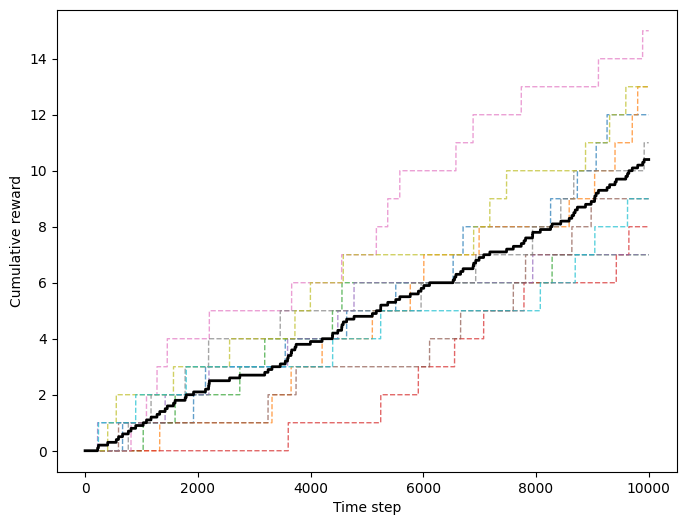

In [10]:
# RANDOM POLICY
if __name__ == "__main__":
    # Set seeds for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Initialize environment
    env = FourRooms()

    # Trial settings
    trial_num = 10
    trial_length = int(1e4)

    # Store rewards
    random_rewards_list = []

    # Run trials
    for e in tqdm(range(trial_num), desc="Run trial", position=0):
        reward_per_trial = []
        reward_counter = 0

        # Reset environment at start of each trial
        state, reward = env.reset()

        # Run each trial
        for t in tqdm(range(trial_length), desc="Episode", position=1, leave=False):

            # Randomly select action
            action = random.choice(["UP", "DOWN", "LEFT", "RIGHT"])

            # Get next state and reward
            next_state, reward = env.step(state, action)

            # Accumulate reward
            reward_counter += reward
            reward_per_trial.append(reward_counter)

            # Reset if goal reached
            if reward == 1:
                state, reward = env.reset() # Reset to the start state if goal is reached
            else:
                state = next_state # Otherwise, update the state
        random_rewards_list.append(reward_per_trial)

# Plot results
plot_func(random_rewards_list)

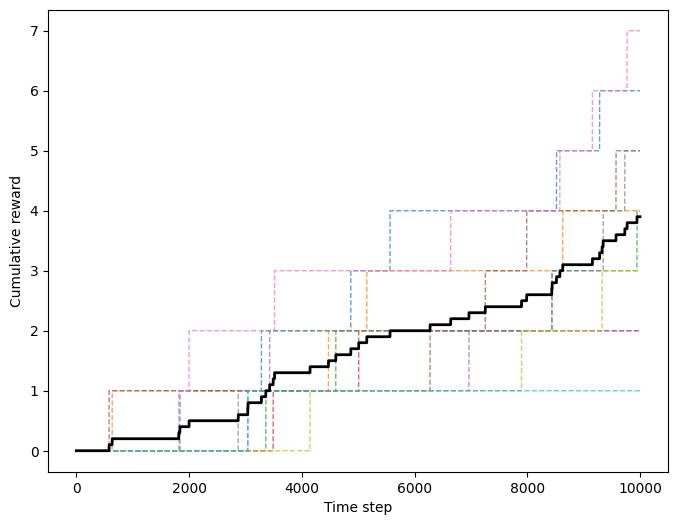

In [12]:
# CIRCULAR POLICY
def circular_policy(counter):
    """
    Selects an action based on a circular movement pattern.

    Args:
        counter (int): The current step count, which determines the action.

    Returns:
        action (str): The action chosen by the policy.
    """
    actions = ["UP", "RIGHT", "DOWN", "LEFT"]     # Define a circular movement
    return actions[counter % len(actions)]        # Cycle through actions

# Circular Policy Simulation
if __name__ == "__main__":
    # Set seeds for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Initialize environment
    env = FourRooms()

    # Trial settings
    trial_num = 10
    trial_length = int(1e4)

    # Store rewards
    circular_rewards_list = []

    # Run trials for Circular policy
    for e in range(trial_num):
        reward_per_trial = []
        reward_counter = 0

        # Reset environment at start of each trial
        state, reward = env.reset()
        step_counter = 0  # Initialize a step counter

        # Run each trial
        for t in range(trial_length):
            # Select action using Circular policy
            action = circular_policy(step_counter)

            # Get next state and reward
            next_state, reward = env.step(state, action)

            # Accumulate reward
            reward_counter += reward
            reward_per_trial.append(reward_counter)

            # Reset if goal reached
            if reward == 1:
                state, reward = env.reset()  # Reset to the start state if goal is reached
                step_counter = 0  # Reset the step counter
            else:
                state = next_state  # Otherwise, update the state

            step_counter += 1  # Increment the step counter

        circular_rewards_list.append(reward_per_trial)

# Plot results for Circular policy
plot_func(circular_rewards_list)

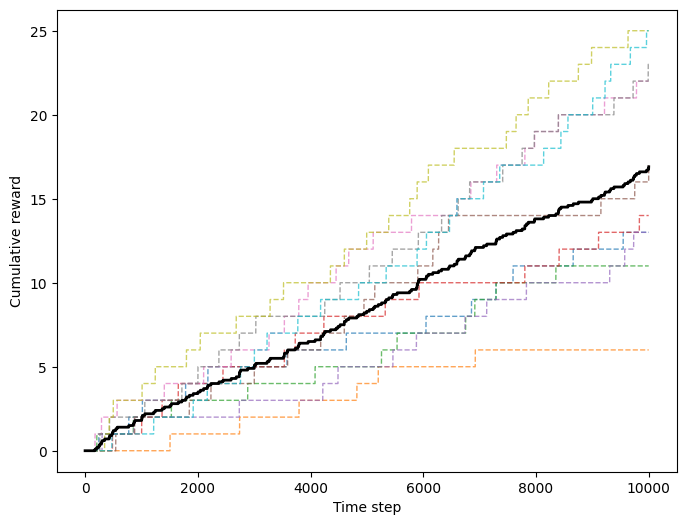

In [14]:
# Q-LEARNING POLICY
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9,
                 exploration_prob=1.0, exploration_decay=0.99, min_exploration_prob=0.1):
        self.env = env
        self.q_table = np.zeros((len(env.state_space), len(env.action_space)))  # Initialize Q-table
        self.learning_rate = learning_rate  # Learning rate
        self.discount_factor = discount_factor  # Discount factor
        self.exploration_prob = exploration_prob  # Exploration probability
        self.exploration_decay = exploration_decay  # Exploration decay rate
        self.min_exploration_prob = min_exploration_prob  # Minimum exploration probability

    def get_action(self, state):
        """Choose an action based on epsilon-greedy strategy."""
        if random.random() < self.exploration_prob:
            return random.choice(list(self.env.action_space.keys()))  # Explore
        else:
            state_index = self.env.state_space.index(state)
            return list(self.env.action_space.keys())[np.argmax(self.q_table[state_index])] # Exploit

    def update_q_table(self, state, action, reward, next_state):
        """Update the Q-table based on the action taken and received reward."""
        state_index = self.env.state_space.index(state)
        action_index = list(self.env.action_space.keys()).index(action)
        next_state_index = self.env.state_space.index(next_state)

        # Update Q-value using the Q-learning formula
        self.q_table[state_index][action_index] += self.learning_rate * \
         (reward + self.discount_factor * np.max(self.q_table[next_state_index]) - \
          self.q_table[state_index][action_index])

    def train(self, trials, trial_length):
        """Train the agent over a number of trials."""
        rewards_list = []

        for e in range(trials):
            state, reward = self.env.reset()  # Reset environment
            reward_counter = 0
            reward_per_trial = []

            for t in range(trial_length):
                action = self.get_action(state)  # Choose action
                next_state, reward = self.env.step(state, action)  # Take action

                self.update_q_table(state, action, reward, next_state)  # Update Q-table
                reward_counter += reward
                reward_per_trial.append(reward_counter)

                # Reset if goal reached
                if reward == 1:
                    state, reward = self.env.reset()  # Reset to start state
                else:
                    state = next_state  # Update state

            # Decay exploration probability
            self.exploration_prob = max(self.min_exploration_prob,
                                        self.exploration_prob * self.exploration_decay)
            rewards_list.append(reward_per_trial)

        return rewards_list

# Q-learning Simulation
if __name__ == "__main__":
    # Set seeds for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Initialize environment and agent
    env = FourRooms()
    agent = QLearningAgent(env)

    # Training settings
    trial_num = 10
    trial_length = int(1e4)

    # Train agent
    q_learning_rewards_list = agent.train(trial_num, trial_length)

    # Plot results for Q-learning
    plot_func(q_learning_rewards_list)

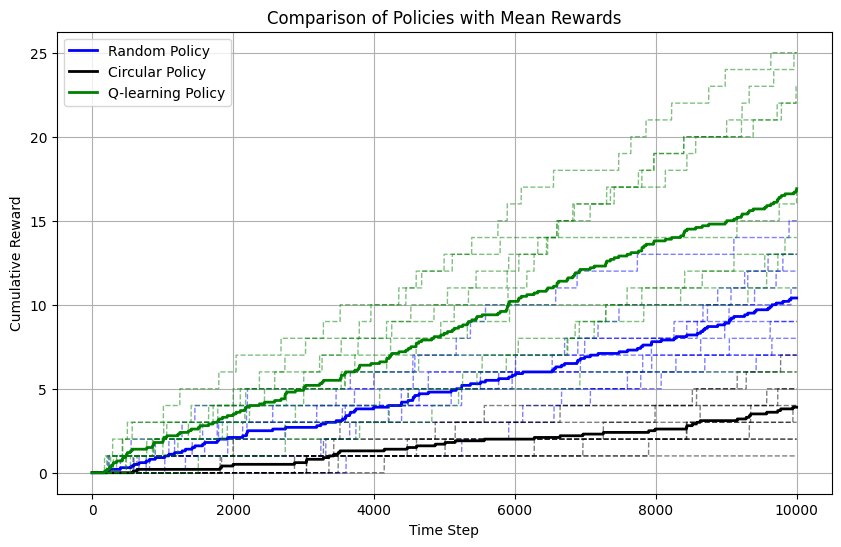

In [16]:
# Plot all policies together with means
def plot_combined_policies(random_rewards, circular_rewards, q_learning_rewards):
    plt.figure(figsize=(10, 6))

    # Plot Random Policy
    for re in random_rewards:
        plt.plot(list(range(len(re))), re, linestyle="--", linewidth=1, alpha=0.5, color='blue')

    # Mean for Random Policy
    mean_random = np.array(random_rewards).mean(axis=0)
    plt.plot(list(range(len(mean_random))), mean_random, linestyle="-", linewidth=2,
             color='blue', label='Random Policy')

    # Plot Circular Policy
    for re in circular_rewards:
        plt.plot(list(range(len(re))), re, linestyle="--", linewidth=1, alpha=0.5, color='black')

    # Mean for Circular Policy
    mean_circular = np.array(circular_rewards).mean(axis=0)
    plt.plot(list(range(len(mean_circular))), mean_circular, linestyle="-", linewidth=2,
             color='black', label='Circular Policy')

    # Plot Q-learning Policy
    for re in q_learning_rewards:
        plt.plot(list(range(len(re))), re, linestyle="--", linewidth=1, alpha=0.5, color='green')

    # Mean for Q-learning Policy
    mean_q_learning = np.array(q_learning_rewards).mean(axis=0)
    plt.plot(list(range(len(mean_q_learning))), mean_q_learning, linestyle="-",
             linewidth=2, color='green', label='Q-learning Policy')

    # Adding labels and title
    plt.ylabel("Cumulative Reward")
    plt.xlabel("Time Step")
    plt.title("Comparison of Policies with Mean Rewards")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the three lists
plot_combined_policies(random_rewards_list, circular_rewards_list, q_learning_rewards_list)